# iRacing session results analysis

In [3]:
import requests
import json
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

 |->
 Input cell: 
 - enter subsession id and cookie to access session results:

In [4]:
subsessionId = '39625833'
custId = '35358774'
cookie = 'F46B25B457D06A07E7C4AE0C783D08076FBC5201E4B9F3DF26696BA0B678B15013E8073C36CAE7A51CB1FB162780C080EF181091432532F1C185474FC136B0F73BCD5EEBAD447F55E29E000385F9E08808BF40E8C46CF6ABEDCE26F1E0500E9C2D6E1D06C57DB8B15E45F572A0FDE9C32A86FBFC5EB96C9C7F25C20F135102CA'

Retrieve data from iRacing server:

In [5]:
cookies = {'irsso_membersv2': cookie}
payload = {'subsessionID': subsessionId, 'custid': custId }
response = requests.post('https://members.iracing.com/membersite/member/GetSubsessionResults', data=payload, cookies=cookies)

resultJson = json.loads(response.text)

Retrieve a list of classes and checks if this is a team race for convenience:

In [6]:
rows = resultJson['rows']
classes = []

isTeamRace = (resultJson['max_team_drivers'] > 1)

for row in rows:
    if row['simsestypename'] != 'Race' or (isTeamRace and row['custid'] >= 0):
        continue
    currentClassName = row['ccName'].replace('+', ' ')
    if not currentClassName in classes:
        classes.append(currentClassName)
if isTeamRace:
    print('This event is a team race')
else:
    print('This event is a single driver race')
print('Available classes:')
print(classes)

This event is a team race
Available classes:
['LMP1 Class', 'Dallara P217', 'GTE Class']


 |->
 Input cell: 
 - Set class filter if needed (or `None` if no class filtering required)
 - Set the car you want to flatten a gap graph (or `None` to flatten on a leader). Use driver name for single races and team name for team races

In [7]:
className = 'Dallara P217'
referenceCar = 'Fuga SimSport LMP2 Black'

Retrieve lap time data for each car in a session and pack it to a pandas dataframe 

In [8]:
df = pd.DataFrame(columns = ['Team name', 'Driver name', 'Class name', 'Finish position', 'Class finish position',  'Lap num', 'Lap time', 'Flags'])

maximumLapNumber = 0

driverIds = {}
for row in rows:
    if row['simsestypename'] != 'Race' or (isTeamRace and row['custid'] >= 0):
        continue
    currentClassName = row['ccName'].replace('+', ' ')
    if not className is None and currentClassName != className:
        continue

    if isTeamRace:
        teamName = urllib.parse.unquote(row['displayname'].replace('+', ' '))
    else:
       teamName = '-'

    lapsResponse = requests.post('https://members.iracing.com/membersite/member/GetLaps?&subsessionid=' + subsessionId + '&groupid=' + str(row['custid']) + "&simsesnum=0", cookies=cookies)
    lapsJson = json.loads(lapsResponse.text)

    drivers = lapsJson['drivers']
    for driver in drivers:
        driverIds[driver['custid']] = urllib.parse.unquote(driver['displayname'].replace('+', ' '))
    prevLapSessTime = 0
    laps = lapsJson['lapData']
    for lap in laps:
        data = {}
        lapTime = (lap['ses_time'] - prevLapSessTime) / 10000.0
        prevLapSessTime = lap['ses_time']
        
        data['Team name'] = teamName
        data['Driver name'] = driverIds[lap['custid']]
        data['Class name'] = currentClassName
        data['Finish position'] = row['finishpos'] + 1
        data['Class finish position'] = row['finishposinclass'] + 1
        data['Lap num'] = lap['lap_num']
        data['Lap time'] = lapTime
        data['Flags'] = lap['flags']

        df = df.append(data, ignore_index=True)

df


,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0
...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2


Compute lap time delta from a reference car for each lap:

In [9]:
lapIdxs = list(df['Lap num'].unique())
grouped = df.groupby('Lap num')

deltas = pd.DataFrame(columns = ['Team name', 'Driver name', 'Lap time', 'Delta'])

if referenceCar == None:
    if isTeamRace:
        referenceCar = df.loc[0]['Team name']
    else:
        referenceCar = df.loc[0]['Driver name']


for lapIdx in lapIdxs:
    lapResults = grouped.get_group(lapIdx)
    currentLeaderTime = -1
    for index, row in lapResults.iterrows():    # first let's find the reference car lap time
        if (isTeamRace and row['Team name'] == referenceCar) or (not isTeamRace and row['Driver name'] == referenceCar):
            currentLeaderTime = row['Lap time']
    if currentLeaderTime > 0:
        currentLapDelta = pd.DataFrame(columns=['Delta'])
        currentLapDelta['Delta'] = lapResults.apply(lambda row: row['Lap time'] - currentLeaderTime, axis=1)
        deltas = deltas.append(currentLapDelta)

deltas = deltas.filter(['Delta'])
df = df.merge(deltas, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0,0.0020
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192,-1.2855
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0,-0.3606
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0,0.5682
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0,-1.7162
...,...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4,4.4931
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0,4.3365
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0,4.4416
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2,94.8363


Compute accumulated gap from a leader car for each car:

In [10]:
if isTeamRace:
    carIdColumn = 'Team name'
else:
    carIdColumn = 'Driver name'
carIds = list(df[carIdColumn].unique())

gaps = pd.DataFrame(columns = ['Delta', 'Gap'])

grouped = df.groupby(carIdColumn)
for carId in carIds:
    carResults = grouped.get_group(carId)
    carResults = carResults.filter(['Delta'])
    gap = 0
    for index, row in carResults.iterrows():
        gap += row['Delta']
        carResults.at[index, 'Gap'] = gap
    gaps = gaps.append(carResults)
gaps = gaps.filter(['Gap'])
df = df.merge(gaps, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta,Gap
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0,0.0020,0.0020
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192,-1.2855,-1.2835
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0,-0.3606,-1.6441
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0,0.5682,-1.0759
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0,-1.7162,-2.7921
...,...,...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4,4.4931,141.2281
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0,4.3365,145.5646
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0,4.4416,150.0062
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2,94.8363,244.8425


Basic data is ready, now we can build some nice graphs:

In [11]:
data = []
labels = []

grouped = df.groupby(carIdColumn)
for carId in carIds:
    labels.append(carId)
    carResults = grouped.get_group(carId)
    data.append(carResults['Gap'].values)


Gap graph:

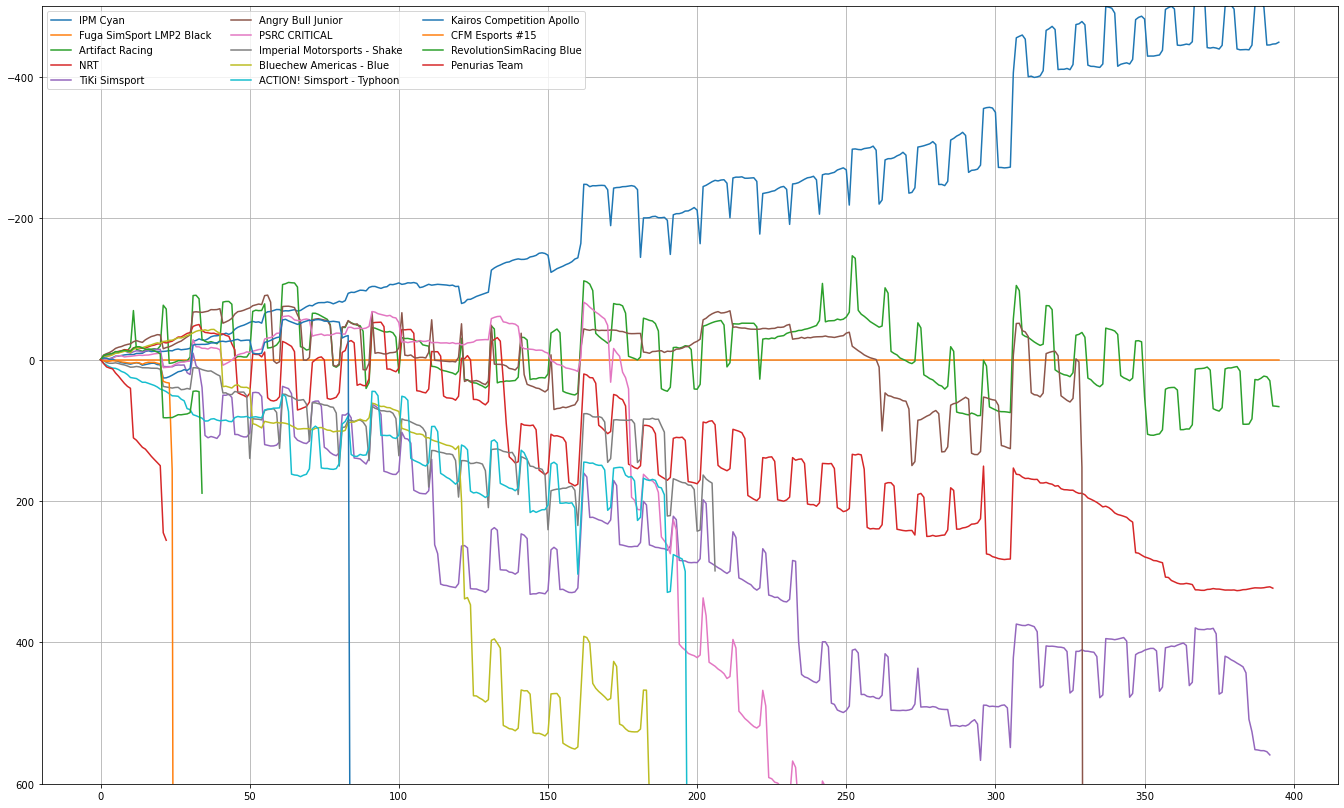

In [12]:
plt.rcParams['figure.figsize'] = [20, 12]

for i, gap in enumerate(data):
    plt.plot(gap, label=labels[i])
plt.legend(ncol=3)
plt.grid(True)
plt.gca().set_ylim([600, -500])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

 |->
 Input cell: 
 - Set a team to build driver lap times histogram or `None` to build it for all drivers

In [13]:
buildHistogramFor = 'Fuga SimSport LMP2 Black'

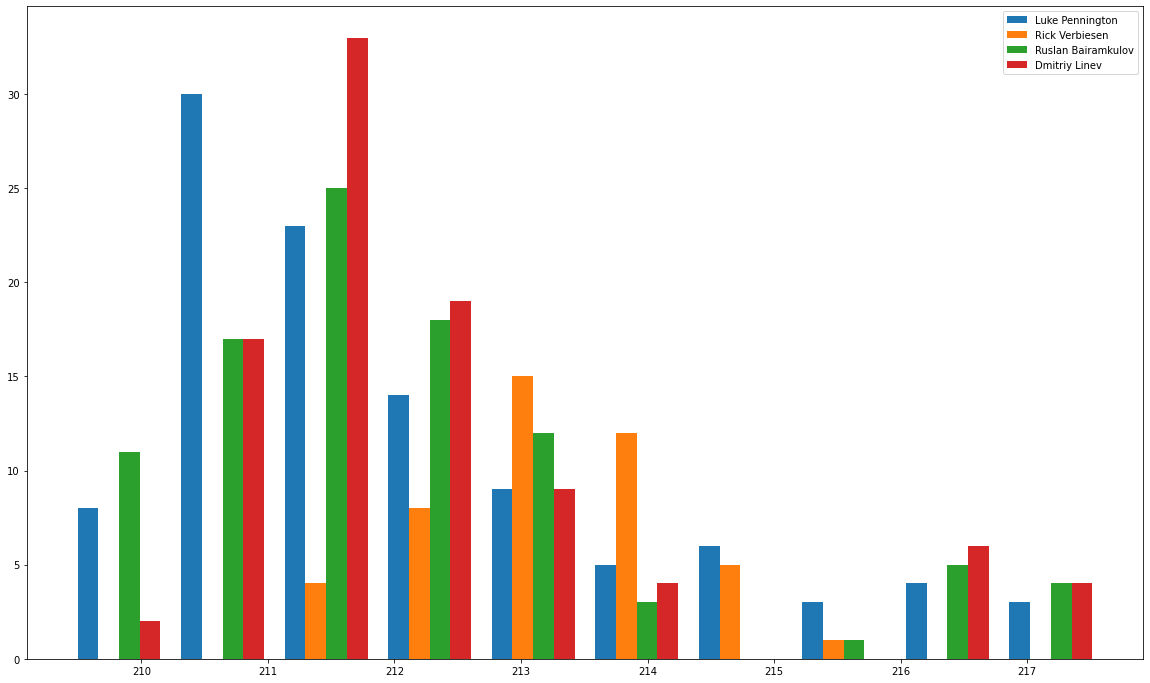

In [14]:
if buildHistogramFor == None:
    if className == None:
        drivers = df['Driver name'].unique()
    else:
        drivers = df[df['Class name'] == className]['Driver name'].unique()
else:
    drivers = df[df['Team name'] == buildHistogramFor]['Driver name'].unique()

lapTimes = {}

fastest = 1e+25

for driver in drivers:
    lapTimes[driver] = df[df['Driver name'] == driver]['Lap time'].tolist()
    local_fastest = min(lapTimes[driver])
    fastest = min(fastest, local_fastest)

for driver in drivers:
    times = lapTimes[driver]
    lapTimes[driver] = [t for t in times if t <= fastest * 1.04]


driverNames = list(lapTimes.keys())
driverLapTimes = list(lapTimes.values())

plt.hist(driverLapTimes, label=driverNames)
plt.legend()

plt.show()

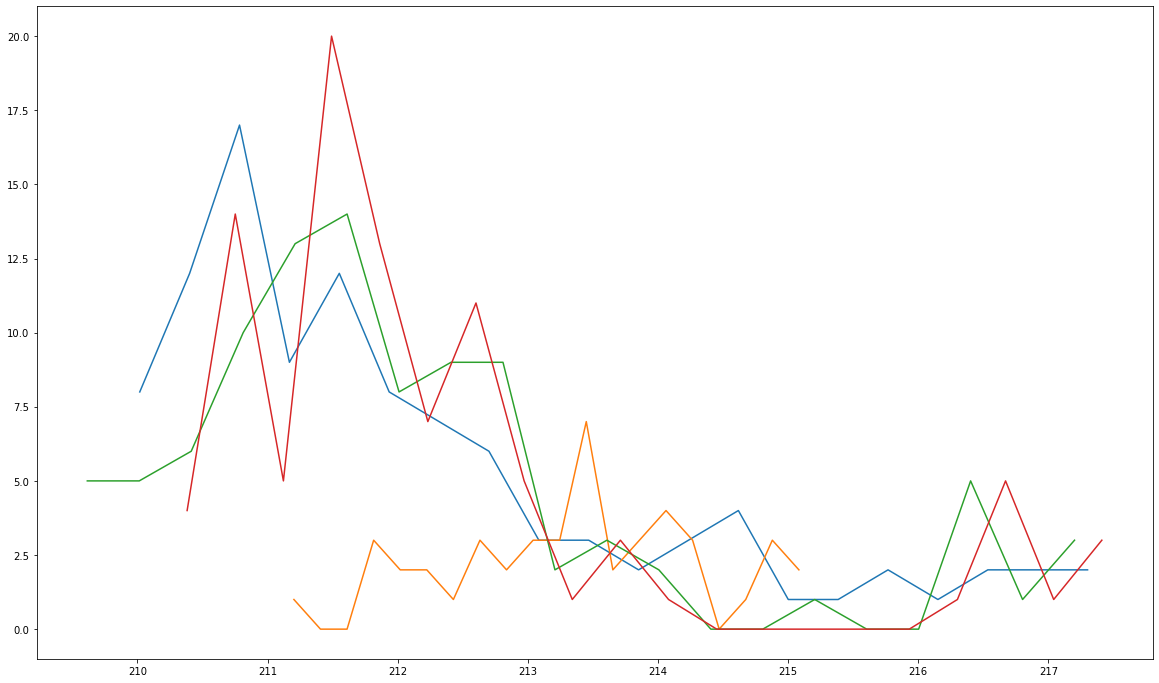

In [47]:
for driver in drivers:
    data = np.asarray(lapTimes[driver])
    y, bin_edges = np.histogram(data, bins=20)
    y = y / data.shape[0]
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_centers, y)

plt.show()


In [40]:
def secondsToLapTime(t):
    minutes = int(t / 60)
    seconds = int(t  - minutes * 60)
    ms = int((t - minutes * 60 - seconds) * 1000)
    return str(minutes) + ":" + str(seconds).zfill(2) + "." + str(ms).zfill(3)

In [41]:
for driver, times in lapTimes.items():
    print('Mean lap time:   ', driver, ': ', secondsToLapTime(np.mean(times)))
    print('Median lap time: ', driver, ': ', secondsToLapTime(np.median(times)))
    print('Lap time st.dev: ', driver, ': ', round(np.std(times), 3), "s")
    print('Valid laps:      ', driver, ': ', len(times))

Mean lap time:    Luke Pennington :  3:32.127
Median lap time:  Luke Pennington :  3:31.565
Lap time st.dev:  Luke Pennington :  1.875 s
Valid laps:       Luke Pennington :  105
Mean lap time:    Rick Verbiesen :  3:33.362
Median lap time:  Rick Verbiesen :  3:33.416
Lap time st.dev:  Rick Verbiesen :  0.962 s
Valid laps:       Rick Verbiesen :  45
Mean lap time:    Ruslan Bairamkulov :  3:32.098
Median lap time:  Ruslan Bairamkulov :  3:31.684
Lap time st.dev:  Ruslan Bairamkulov :  1.843 s
Valid laps:       Ruslan Bairamkulov :  96
Mean lap time:    Dmitriy Linev :  3:32.313
Median lap time:  Dmitriy Linev :  3:31.757
Lap time st.dev:  Dmitriy Linev :  1.771 s
Valid laps:       Dmitriy Linev :  94
